In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import torch
from tqdm import tqdm
from src.models import OldSpaceNet
from src.utils import spatial_correlation, shuffle_inds

In [2]:
n_in = 2 # 2 position inputs 
n_out = 100 # no. of spatial representations

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = OldSpaceNet(n_in, n_out, device = device)
model = model.load("./saved_models/FF")

/home/m/miniconda3/envs/ml/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# evaluate on 32x32 grid
model.to('cpu')
res = 64
x = np.linspace(-1, 1, res)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)
p = model.spatial_representation(u).detach().numpy()
mask = np.mean(p, axis = 0) > -np.inf

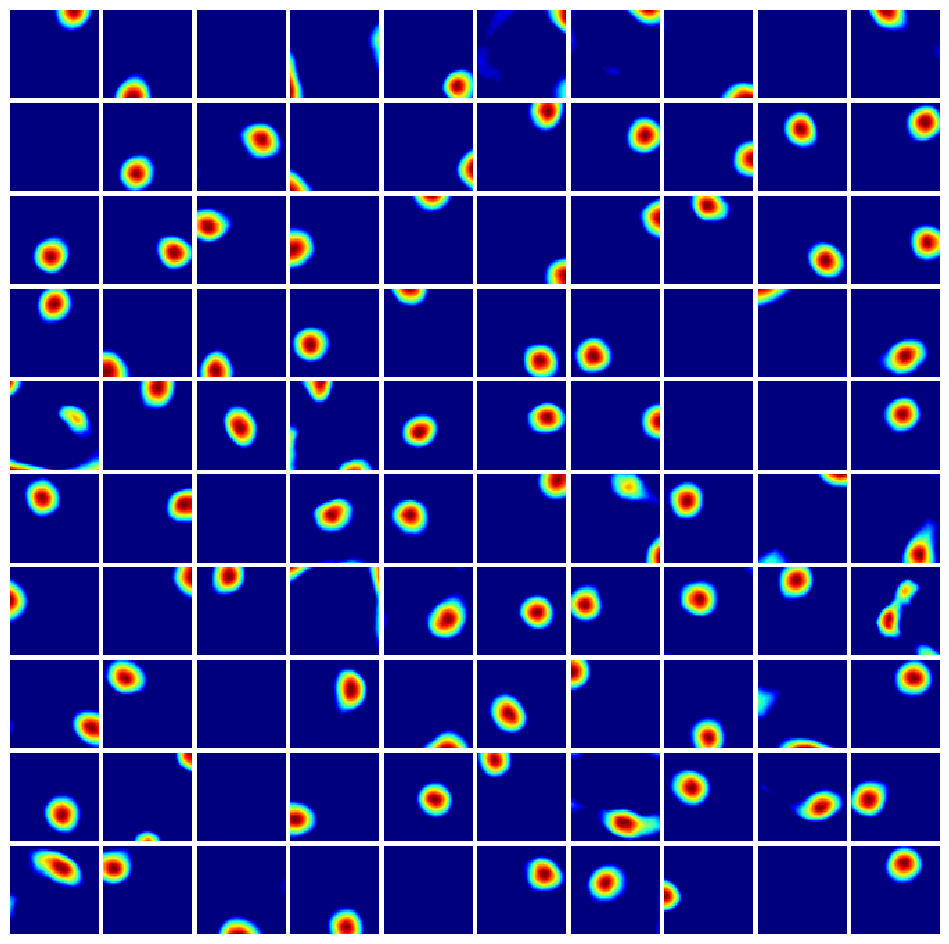

In [4]:
n_p = 10
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(p.T[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(res, res)

    ax[row, col].imshow(representation, cmap = "jet", interpolation = "none")

plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [21]:
relu = torch.nn.ReLU()
r0 = torch.nn.Parameter(torch.rand((n_out, n_out), dtype=torch.float32)*0.1)
R = lambda : r0

# create a torch optimizer
optimizer = torch.optim.Adam([r0], lr=1e-3)
losses = []
steps = 10000
# define a training loop
for _ in tqdm(range(steps)):
    optimizer.zero_grad()
    
    a = r0.T@r0 - torch.eye(len(r0)) # be orthogonal
    b = r0@r0.T - torch.eye(len(r0)) # be orthogonal
    c = torch.linalg.det(r0) - 1 # proper rotation
    loss = torch.mean(a**2)  + torch.mean(b**2) + torch.mean(c**2) + torch.mean(relu(-r0@torch.tensor(p.T)))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

plt.semilogy(losses)

 48%|████▊     | 4804/10000 [00:15<00:17, 305.61it/s]


KeyboardInterrupt: 

In [22]:
w = R().detach().numpy()

In [23]:
np.linalg.det(w)

1.3058244e-09

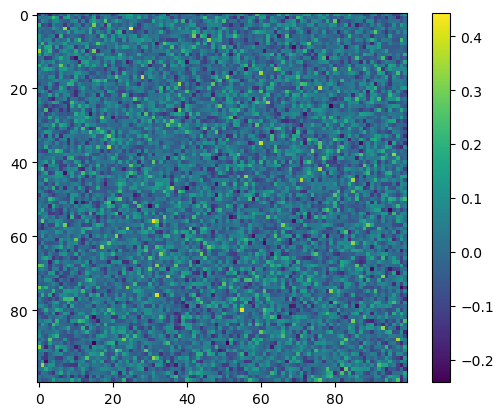

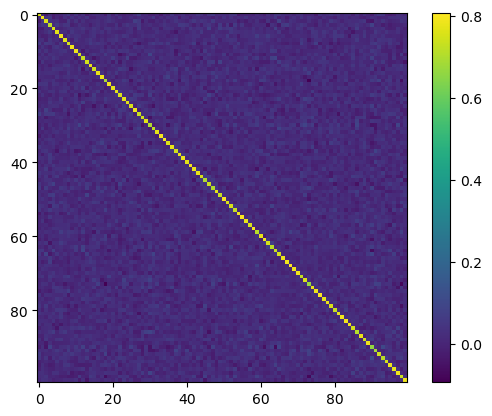

In [24]:
plt.imshow(w)
plt.colorbar()
plt.show()
plt.imshow(w@w.T)
plt.colorbar()
plt.show()

In [25]:
z = w@p.T

In [26]:
z.shape, p.shape, w.shape

((100, 4096), (4096, 100), (100, 100))

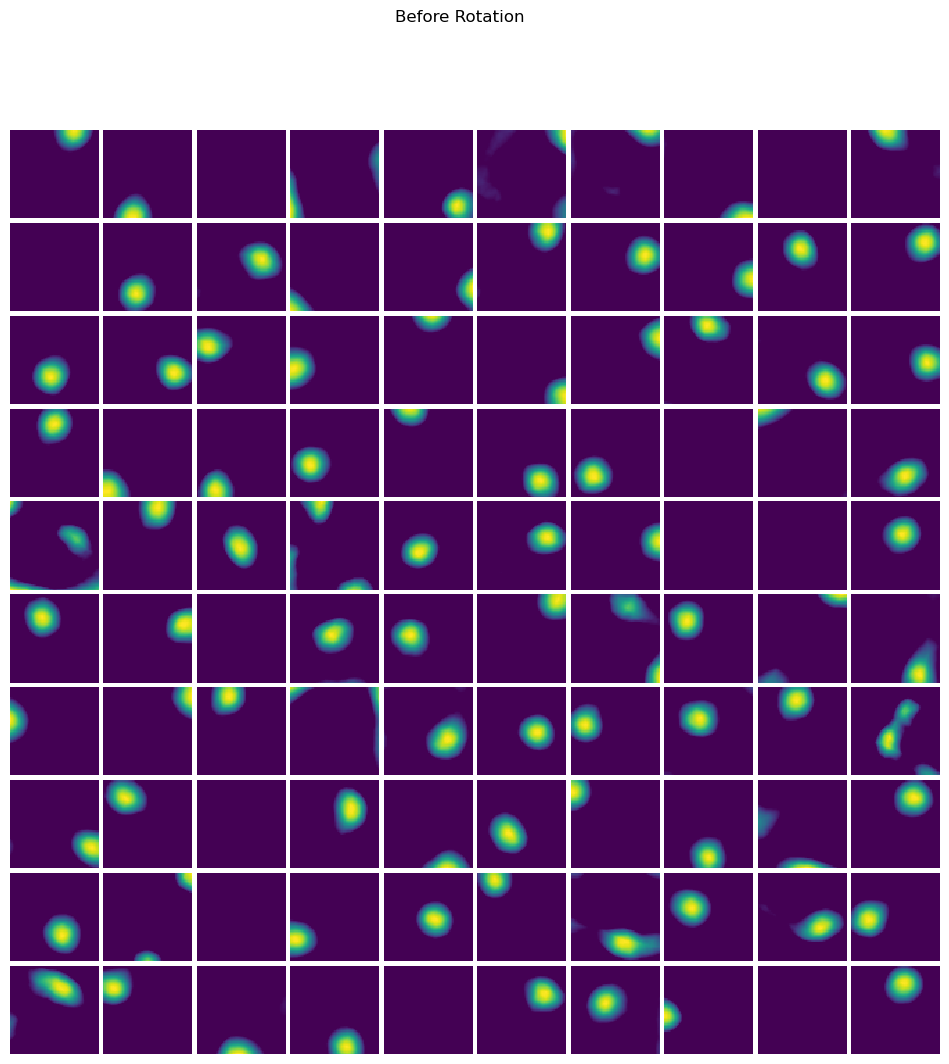

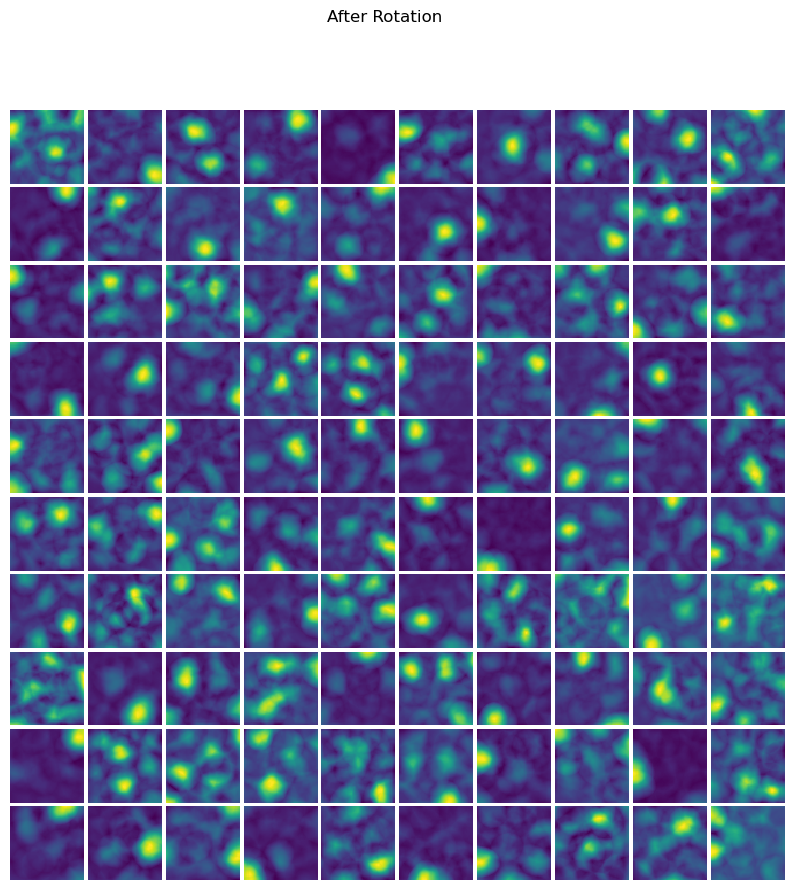

In [27]:
n_p = 10
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(p.T[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")
    representation = representation.reshape(res, res)
    ax[row,  col].imshow(representation, interpolation = "none")

plt.suptitle("Before Rotation")
plt.subplots_adjust(wspace=0.05, hspace=0.05)

n_p = 10
fig, ax = plt.subplots(n_p, n_p, figsize =(10, 10))

for i, representation in enumerate(z[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(res, res)
    ax[row, col].imshow(representation, interpolation = "none")

plt.suptitle("After Rotation")
plt.subplots_adjust(wspace=0.05, hspace=0.05)

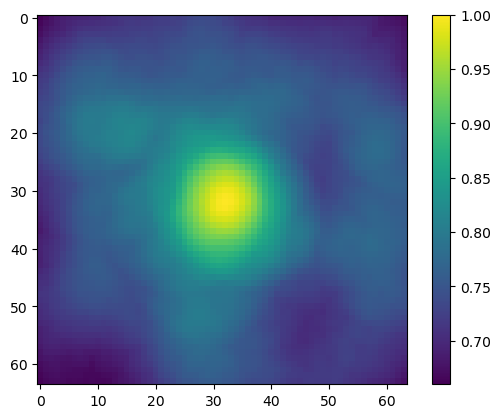

In [28]:
ps = z[:,res**2//2 + res//2]
sim = np.exp(-np.sum((ps[None] - z.T)**2, axis = -1))
plt.imshow(sim.reshape(res,res), interpolation = "None")
plt.colorbar()

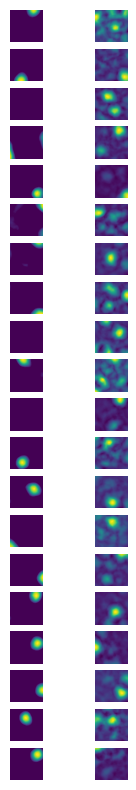

In [29]:
fig, ax = plt.subplots(20, 2, figsize = (2, 10))

for i in range(20):
    # ax[i,1].imshow(z[i].reshape(32,32),vmax = np.amax(p[:,i]))
    vmax = np.maximum(np.amax(z[i]), np.amax(p[:,i]))
    ax[i,1].imshow(z[i].reshape(res,res))#,vmax = vmax)

    ax[i, 0].imshow(p[:,i].reshape(res,res))
    ax[i,0].axis("off")
    ax[i,1].axis("off")

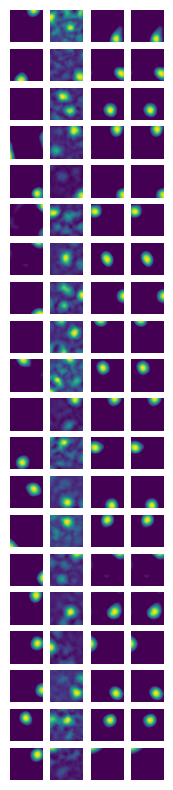

In [30]:
fig, ax = plt.subplots(20, 4, figsize = (2, 10))

for i in range(20):
    # ax[i,1].imshow(z[i].reshape(res,res),vmax = np.amax(p[:,i]))
    ind = np.argmax(w[i])

    ax[i, 0].imshow(p[:,i].reshape(res,res))
    ax[i, 1].imshow(z[i].reshape(res,res))#,vmax = np.amax(p[:,i]))

    ax[i, -2].imshow(p[:,ind].reshape(res,res))
    ax[i, -1].imshow(p[:,ind].reshape(res,res))

    ax[i,0].axis("off")
    ax[i,1].axis("off")
    ax[i,-2].axis("off")
    ax[i,-1].axis("off")

In [15]:


n_shuffles = 1000
shuffle_corrs = []

for i in range(n_shuffles):
    inds = shuffle_inds(n_out)
    shuffle_corrs.append(spatial_correlation(p.T, p.T[inds]))

shuffle_corrs = np.concatenate(shuffle_corrs)

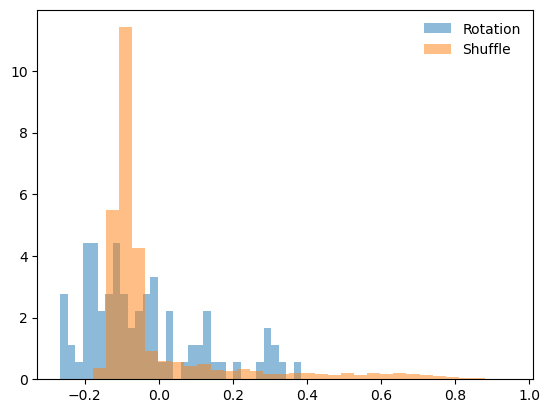

In [16]:
corr = spatial_correlation(z, p.T)

plt.hist(corr, bins = 32, density=True, alpha = 0.5, label = "Rotation");
plt.hist(shuffle_corrs, bins = 32, density=True, alpha = 0.5, label = "Shuffle");
plt.legend(frameon = False)

In [ ]:
p.shape